In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/an2dl-dataset/public_data.npz
/kaggle/input/submissionphase/metadata
/kaggle/input/submissionphase/model.py
/kaggle/input/submissionphase/SubmissionModel/fingerprint.pb
/kaggle/input/submissionphase/SubmissionModel/saved_model.pb
/kaggle/input/submissionphase/SubmissionModel/keras_metadata.pb
/kaggle/input/submissionphase/SubmissionModel/variables/variables.index
/kaggle/input/submissionphase/SubmissionModel/variables/variables.data-00000-of-00001


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import glob
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB4
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import albumentations
from tensorflow.keras.applications import EfficientNetB0

2.13.0


In [4]:
import numpy as np

# Assuming the dataset is in the /kaggle/input/ directory
dataset_path = '/kaggle/input/an2dl-dataset/public_data.npz'

# Load the data
data = np.load(dataset_path,allow_pickle=True)


image_data=data['data']
image_labels=data['labels']

In [5]:
# Get unique values and their counts
unique_values, counts = np.unique(image_labels, return_counts=True)

# Combine unique values and their counts into a dictionary
value_counts = dict(zip(unique_values, counts))
value_counts

{'healthy': 3199, 'unhealthy': 2001}

In [6]:
def preprocess_image(data):
    images = []
    image_data = data['data']
    image_labels = data['labels']

    # Shuffle the data
    shuffled_image_data, shuffled_image_labels = shuffle(image_data, image_labels, random_state=42)

    # Iterate through files in the specified folder
    for image in shuffled_image_data:
        # Normalize image pixel values to a float range [0, 1]
        image = (image / 255).astype(np.float32)

        # Resize the image to 32x32 pixels
        image = tfkl.Resizing(224, 224)(image)

        if image is not None:
            images.append(image)

    # Convert labels to one-hot encoding
    unique_labels = np.unique(shuffled_image_labels)
    print(unique_labels,shuffled_image_labels)
    label_dict = {label: i for i, label in enumerate(unique_labels)}
    labels = np.array([label_dict[label] for label in shuffled_image_labels])
    one_hot_labels = np.eye(len(unique_labels))[labels]
    print([one_hot_labels[0],one_hot_labels[1],one_hot_labels[2],one_hot_labels[3],one_hot_labels[4]])
    print([labels[0],labels[1],labels[2],labels[3],labels[4]])
    
    return np.array(images), one_hot_labels


images,labels=preprocess_image(data)

['healthy' 'unhealthy'] ['healthy' 'healthy' 'unhealthy' ... 'unhealthy' 'healthy' 'unhealthy']
[array([1., 0.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.])]
[0, 0, 1, 0, 1]


In [8]:
def filter_images_by_intensity(images, labels, thresholds):
    # Calculate the average intensity for each image
    filtered_images=[]
    filtered_image_index=[]
    for i in range(len(images)):
      average_intensity = np.mean(images[i])
      mask1 = (thresholds[0] <= average_intensity) & (average_intensity <= thresholds[1])  #shrek images
      mask2 = (thresholds[2] <= average_intensity) & (average_intensity <= thresholds[3])  #trololo images

      if mask1 or mask2:
        filtered_images.append(images[i])
        filtered_image_index.append(i)

      # Use boolean indexing to filter out elements
    filtered_images = np.delete(images, filtered_image_index, axis=0)
    filtered_labels = np.delete(labels, filtered_image_index, axis=0)

    return filtered_images,filtered_labels

thresholds = [0.25200000, 0.2540000000, 0.4440000000000, 0.4450000000]
from tensorflow.keras.utils import to_categorical
filtered_images,filtered_labels = filter_images_by_intensity(images, labels, thresholds)


In [9]:
def calculate_class_weights(filtered_labels):
    # Assuming 'filtered_labels' is a one-hot encoded array
    # Convert one-hot encoded labels to integer class labels
    y = np.argmax(filtered_labels, axis=1)

    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {}

    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = total_samples / (2.0 * class_count)
        class_weights[class_label] = class_weight

    return class_weights

# Assuming 'filtered_labels' contains the one-hot encoded labels for the binary classification problem
class_weights = calculate_class_weights(filtered_labels)
print("Class weights:", class_weights)

Class weights: {0: 0.8063994828700711, 1: 1.3159282700421941}


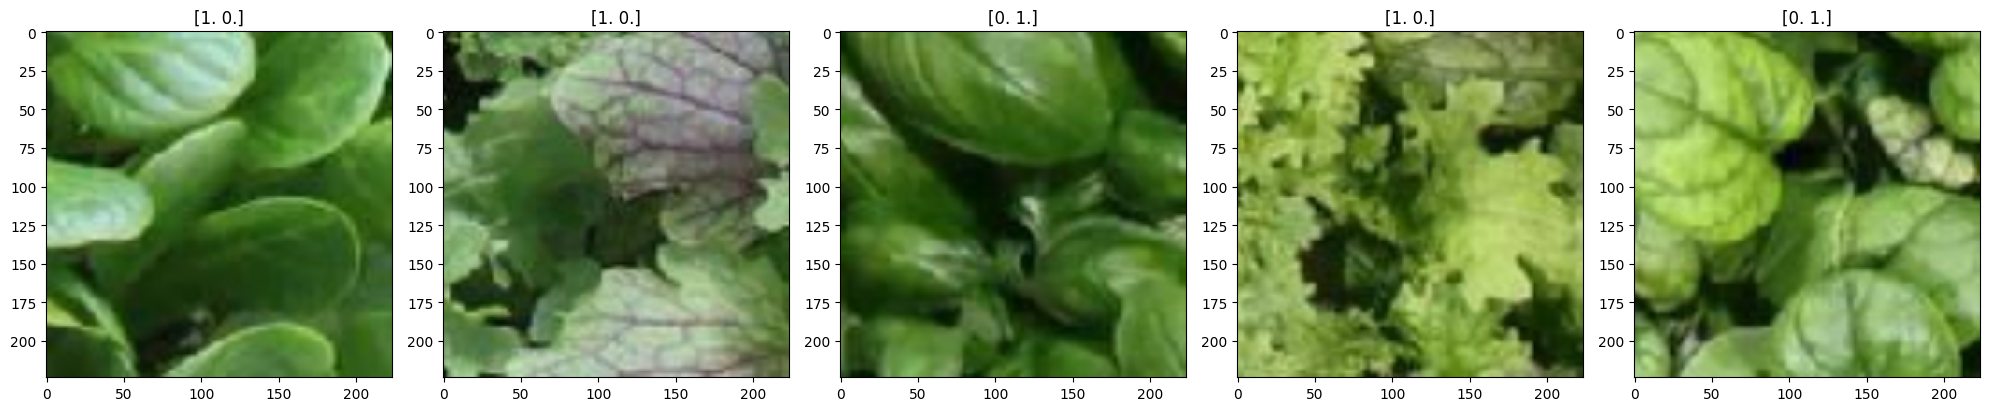

In [10]:
# Display a sample of images from the training-validation dataset
num_img = 5
z=0
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i%num_img]
    ax.imshow(filtered_images[i+z], cmap='gray')
    ax.set_title(f'{filtered_labels[i+z]}')  # Show the corresponding digit label

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [11]:
# Split the data into training (90%) and temporary data (10%)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(filtered_images, filtered_labels, test_size=0.1, random_state=seed)

# Now, split the combined training and validation data into training (90%) and validation (10%)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, random_state=seed, stratify=Y_train_val)


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {Y_test.shape}")

X_train shape: (3820, 224, 224, 3), y_train shape: (3820, 2)
X_val shape: (546, 224, 224, 3), y_val shape: (546, 2)
X_test shape: (624, 224, 224, 3), y_test shape: (624, 2)


In [12]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 32
epochs = 50
input_shape = X_train.shape[1:]
output_shape = 2

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Batch Size: 32, Epochs: 100
Input Shape: (224, 224, 3), Output Shape: 2


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.35),  # Increased rotation factor
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.2),  # Increased contrast factor
        layers.RandomBrightness(factor=0.2),  # Increased brightness factor
    ],
    name="img_augmentation",
)


In [ ]:
def create_model(input_shape):
    
    inputs = layers.Input(shape=input_shape)
    x=img_augmentation(inputs)
    
    model=EfficientNetB0(input_tensor=x, include_top = False, 
                             weights = 'imagenet', 
                             drop_connect_rate=0.4)
    model.trainable=False
    
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

leaf_model = create_model(input_shape)


In [ ]:
def model_fitter(input_shape):
        
    leaf_model = create_model(input_shape)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True, verbose=1)
        
    #reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, min_lr = 1e-6, mode = 'min', verbose = 1)
    #class_weight={0: 0.37}
    history = leaf_model.fit(X_train*255,Y_train, validation_data = (X_val*255,Y_val), epochs= epochs, batch_size = batch_size,
                             callbacks=[es],class_weight=class_weights)

    
    leaf_model.save('LecunTanh'+'.h5')  
    
    return history,leaf_model

In [ ]:
results,leaf_model = model_fitter(input_shape)

In [ ]:
# Evaluate the model on the test set
test_accuracy = leaf_model.evaluate(X_test*255,Y_test,verbose=1)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('LecunTanh.h5')


In [ ]:
# Set all MobileNetV2 layers as trainable
#ft_model.trainable = True
for i, layer in enumerate(ft_model.layers):
    method = layer.with_name_scope  # Replace this with your actual method
    class_of_method = method.__self__
    print(i, layer.name, layer.trainable,layer.with_name_scope,type(layer.with_name_scope),class_of_method)

In [ ]:

def unfreeze_model(ft_model):
    # unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in ft_model.layers[-50:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5,weight_decay=5e-4)
    ft_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(ft_model)


In [ ]:
for i, layer in enumerate(ft_model.layers):
    method = layer.with_name_scope  # Replace this with your actual method
    class_of_method = method.__self__
    print(i, layer.name, layer.trainable)

In [ ]:
epochs=50
batch_size=32
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    
]
ft_history = ft_model.fit(X_train*255,Y_train, validation_data = (X_val*255,Y_val), epochs= epochs, batch_size = batch_size,callbacks = callbacks,class_weight=class_weights)


In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(ft_history.history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(ft_history.history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(ft_history.history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(ft_history.history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(ft_history.history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, ft_history.history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()


In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(X_test*255,Y_test,verbose=1)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

# Assuming ft_model is your trained model and X_test, Y_test are your test data
# Make predictions on the test set
predictions = ft_model.predict(X_test * 255)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Get class labels
class_names = [str(i) for i in range(conf_mat.shape[0])]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


In [ ]:
ft_model.save("lecun")

In [ ]:
import numpy as np

# Assuming ft_model is your pre-trained model
# X_test is your test set input data
# Y_test is your test set true labels

# Get model predictions
predictions_probs = ft_model.predict(X_test * 255)

# Convert probabilities to class predictions
predictions = np.argmax(predictions_probs, axis=1)

# Print true labels, model predictions, and predicted probabilities
for true_label, predicted_label_probs, predicted_label, actual_label in zip(Y_test, predictions_probs, predictions, np.argmax(Y_test, axis=1)):
    print(f'True Class: {actual_label}, Predicted Class: {predicted_label}, Predicted Probabilities: {predicted_label_probs}, Actual Label: {true_label}')


In [ ]:
#This part is for model.py for image resizing

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing as tfkl

deneme_new = []

for image in deneme:
    image_resized = tfkl.Resizing(224, 224)(image)
    deneme_new.append(image_resized)

deneme_new = tf.convert_to_tensor(deneme_new, dtype=tf.float32)
deneme_new = deneme_new.numpy()

print(type(deneme_new))  # This should print <class 'numpy.ndarray'>
print(type(deneme_new[0]))  # This should print <class 'numpy.ndarray'>


In [ ]:
deneme_new.shape